I have prepared this data to model with multivariable regression according to this specification:

$$ Property crime = \alpha + log(Population) + fraction(larceny) + fraction(Murder) + fraction(car theft)$$

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import cross_val_score

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline

In [2]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)
drop_df = df.drop('Rape\n(revised\ndefinition)1',axis=1) #removing column because only NaN values
crime_df = drop_df[:-3] #Last three rows are not data

In [3]:
property_crime = pd.DataFrame()
n = 10000 #per 1000 people

#features
property_crime['log_population'] = np.log(crime_df['Population'])
property_crime['frac_assault'] = (crime_df['Aggravated\nassault']/crime_df['Population'])*n
property_crime['frac_robbery'] = (crime_df['Robbery']/crime_df['Population'])*n

#dependent variable
property_crime['log_property_crime'] = crime_df['Property\ncrime']

drop_index = np.concatenate((np.where(property_crime['log_population'] == property_crime['log_population'].max())[0], 
                            np.where(property_crime['log_property_crime'] == 0)[0],
                            property_crime['frac_assault'].nlargest(21).index,
                            property_crime['frac_robbery'].nlargest(20).index))
property_crime = property_crime.drop(drop_index, axis=0)

property_crime['log_property_crime'] = np.log(property_crime['log_property_crime'])

drop_index_new = np.concatenate((property_crime['log_property_crime'].nlargest(2).index, 
                                 property_crime['log_property_crime'].nsmallest(1).index))
property_crime = property_crime.drop(drop_index_new, axis=0)

property_crime.head()

,log_population,frac_assault,frac_robbery,log_property_crime
0,7.528869,0.000000,0.000000,2.484907
1,7.854381,11.641444,0.000000,3.178054
2,7.953670,10.541110,0.000000,2.772589
4,8.762177,25.046963,6.261741,5.407172
5,8.316056,4.891171,7.336757,3.828641


Here I chose to take the log values of the property crime and the population to normalize the distributions. Then I took the features for larceny, robbery, and murder and divided each one by the population so that the features is in fraction of the feature per population.

paramaters:
Intercept        -4.990265
log_population    1.032219
frac_assault      0.032246
frac_robbery      0.085978
dtype: float64 

p-values:
Intercept         6.441840e-40
log_population    5.243833e-86
frac_assault      1.177158e-08
frac_robbery      3.177258e-08
dtype: float64 

R^2:
0.7960588271484446 

convidence intervals:
                       0         1      wide
Intercept      -5.629642 -4.350889  1.278753
log_population  0.959194  1.105244  0.146049
frac_assault    0.021422  0.043070  0.021649
frac_robbery    0.056174  0.115782  0.059607


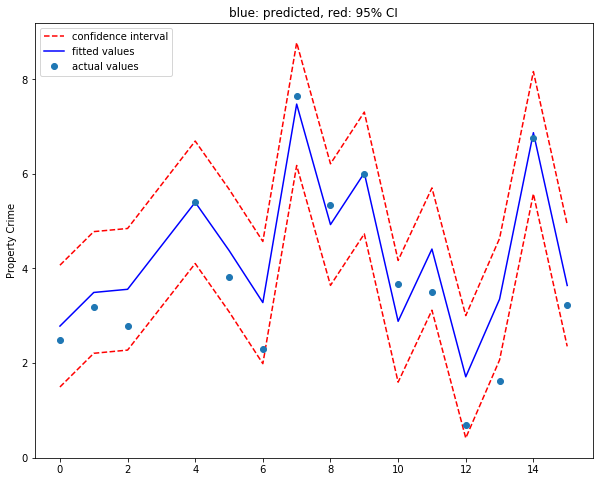

In [4]:
# dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'log_property_crime ~ log_population+frac_assault+frac_robbery'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=property_crime).fit()

print('paramaters:')
print(lm.params, '\n')
print('p-values:')
print(lm.pvalues, '\n')
print('R^2:')
print(lm.rsquared, '\n')

      
conf_int = lm.conf_int()
conf_int['wide'] = abs(conf_int[1] - conf_int[0])
print('convidence intervals:')
print(conf_int)
      
# Use wls_prediction_std to build confidence intervals

prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure(figsize=(10,8))
plt.plot(iv_u[0:15], '--', color='r', label='confidence interval')
plt.plot(iv_l[0:15], '--', color='r')
plt.plot(lm.fittedvalues[0:15], color='b', label='fitted values')
plt.plot(property_crime['log_property_crime'][0:15], 'o', label='actual values')
plt.title('blue: predicted, red: 95% CI')
plt.ylabel('Property Crime')
plt.legend(loc='best')
plt.show()

Here, our model where the outcome Property Crime is predicted by the features population, larceny, robbery, and murder (percent of population) explains $79.6%$ of the variance in property crime. 

The intercept is negative and the highest increase in property crime comes from population (1.03)). 

population has the widest confidence interval.

In [5]:
pred = lm.predict(property_crime)

In [6]:
root_mean_square_error = np.sqrt(np.mean((property_crime['log_property_crime'] - pred )**2))
print(root_mean_square_error)

0.646889752532963


In [7]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_property_crime   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     400.7
Date:                Fri, 08 Feb 2019   Prob (F-statistic):          5.78e-106
Time:                        12:54:04   Log-Likelihood:                -306.81
No. Observations:                 312   AIC:                             621.6
Df Residuals:                     308   BIC:                             636.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.9903      0.325    -15.358      0.000      -5.630      -4.351
log_population     1.0322      0.037     27.814      0.000       0.959       1.105
frac_assault       0.0322      0.006      5.862      0.000       0.021       0.043
frac_robbery       0.0860      0.015      5.676      0.000       0.056       0.116
==============================================================================
Omnibus:                       24.391   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.604
Skew:                          -0.508   Prob(JB):                     4.14e-09
Kurtosis:                       4.392   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = property_crime['log_property_crime'].values.reshape(-1, 1)
X = property_crime[['log_population','frac_assault','frac_robbery']]
lr = regr.fit(X, Y)

cross_validation = cross_val_score(lr, X, Y, cv=3)

print(cross_validation)
print('mean: {}%'.format(np.mean(cross_validation)*100))
print('standard deviation: {}%'.format(np.std(cross_validation)*100))

[0.81317953 0.76724782 0.74815675]
mean: 77.61946991388888%
standard deviation: 2.728889433547511%


Cross validation looks good! - chose 3 since there are only about 300 points in the data set.

# Try on different data

In [41]:
df_test = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls', header=4)
drop_df_test = df_test.drop('Rape\n(revised\ndefinition)1',axis=1) #removing column because only NaN values
crime_df_test = drop_df_test[:-3] #Last three rows are not data

In [42]:
test = pd.DataFrame()
n = 10000 #per 1000 people

#features - NY
test['log_population'] = np.log(crime_df['Population'])
test['frac_assault'] = (crime_df['Aggravated\nassault']/crime_df['Population'])*n
test['frac_robbery'] = (crime_df['Robbery']/crime_df['Population'])*n

#dependent variable - colorado 
test['log_test'] = crime_df_test['Property\ncrime']

drop_index = np.concatenate((np.where(test['log_population'] == test['log_population'].max())[0], 
                            np.where(test['log_test'] == 0)[0],
                            test['frac_assault'].nlargest(21).index,
                            test['frac_robbery'].nlargest(20).index))
test = test.drop(drop_index, axis=0)

test['log_test'] = np.log(test['log_test'])

drop_index_new = np.concatenate((test['log_test'].nlargest(2).index, 
                                 test['log_test'].nsmallest(1).index))
test = test.drop(drop_index_new, axis=0)

test.head()

,log_population,frac_assault,frac_robbery,log_test
0,7.528869,0.000000,0.000000,2.397895
1,7.854381,11.641444,0.000000,3.891820
4,8.762177,25.046963,6.261741,8.265650
5,8.316056,4.891171,7.336757,5.318120
6,7.484930,16.844469,0.000000,1.945910


In [43]:
X1 = test[['log_population', 'frac_assault', 'frac_robbery']]
Y1 = test['log_test']
predict = lr.predict(test[['log_population', 'frac_assault', 'frac_robbery']])
predict = np.concatenate(predict)

In [45]:
score = lr.score(X1,Y1)
print('R^2 with diff data:', score)

R^2 with diff data: -0.5478908235196802


RMS =  2.1547188930772276


/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


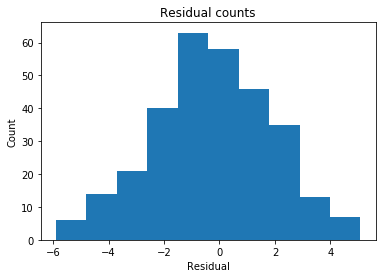

In [25]:
root_mean_square_error = np.sqrt(np.mean((test['log_test'] - predict)**2))
print('RMS = ', root_mean_square_error)

residual_other = test['log_test'] - pred 
plt.hist(residual_other)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

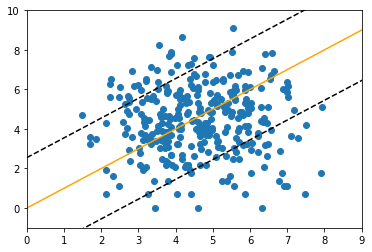

In [50]:
plt.scatter(pred, test['log_test'])
x = np.linspace(0,10,100)
plt.plot(x, x, '-', c='orange')
plt.plot(x, x+2.55, '--', c='k')
plt.plot(x, x-2.55, '--', c='k')
plt.xlim(0,9)
plt.ylim(-1,10)
plt.show()

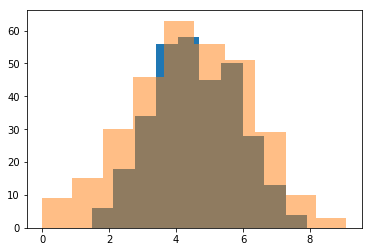

In [51]:
plt.hist(pred)
plt.hist(test['log_test'], alpha=0.5);

This model is not very good at predicting other data sets.